# Test kernel

je teste ici des modèles de CNN

je vais varier principalement le kernel , (11,7,3), (7,5,3),  (5,3,3)

In [1]:
import os
import sys
sys.path.append('../src')
import time

from balance import load_balanced
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score

import torch.nn as nn
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary
from torch import optim
from sklearn.model_selection import train_test_split
import joblib

In [2]:
from tqdm.notebook import tqdm

In [25]:
import seaborn as sns

## MODEL

In [3]:
def evaluate_model(model, test_set):
    X, y_true = test_set[:]
   
    model.eval()
    criterion = nn.CrossEntropyLoss()
    # Calcul de la fonction de perte
    
    with torch.no_grad():
        # Prédiction du modèle pour un batch donné
        y_pred = model(X)

    loss_test = criterion(y_pred, y_true)
    
    y_pred = np.argmax(y_pred.detach().numpy(),axis=1)
    y_true = y_true.numpy()
    accuracy = precision_score(y_true, y_pred,average='macro')
    recall = recall_score(y_true, y_pred,average='macro')
    return y_true, y_pred, accuracy, recall, loss_test.item()
    
def train_a_model(model,train_loader,test_set,epochs = 100,lr=1e-3,device='cpu',outmodelname=None):


  
    
    best_accuracy = 0
    optimizer = optim.Adam(model.parameters(), lr)

       # Définir le scheduler ReduceLROnPlateau
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                    mode='min',
                                                    factor=0.5,
                                                    patience=5,
                                                    verbose=True)
    # Définition de la fonction de perte
    criterion = nn.CrossEntropyLoss()

    loss_list = []
    loss_list_test = []

    accuracy_list = []
    start = time.time()
    
    for epoch in range(epochs):
        progress_bar = tqdm(
            train_loader, desc="train", leave=True, disable=False
        )
        # Dans ce mode certaines couches du modèle agissent différemment
        model.train()
        loss_total = 0
        
        for i, batch in enumerate(progress_bar):
            # Batch de données
            X_batch, y_batch = batch
            
            # Device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # Gradient mis 0
            model.zero_grad()
    
            # Calcul de prédiction
            y_pred = model(X_batch)
    
            # Calcul de la fonction de perte
            loss = criterion(y_pred, y_batch)
    
            # Backpropagation : calculer le gradient de la loss en fonction de chaque couche
            loss.backward()
            
            # Clipper le gradient entre 0 et 1 pour plus de stabilité
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Descente de gradient : actualisation des paramètres
            optimizer.step()
            
            loss_total += loss.item()

        y_true, y_pred, accuracy, recall, loss = evaluate_model(model, test_set)
        if accuracy > best_accuracy and outmodelname is not None:
            joblib.dump(model, outmodelname)
            print('save model')
            best_accuracy = accuracy
        loss_list.append(loss_total/len(train_loader))
        loss_list_test.append(loss)
        accuracy_list.append(accuracy)
        print(f"Epoch : {epoch+1}/{epochs} -- Training loss {loss_total/len(train_loader)}, --- Val loss {loss}, --- accuray : {accuracy}, --- recall : {recall}")
    
    end = time.time()
    
    print("execution time: ",end - start)
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(loss_list,label='loss train')
    ax.plot(loss_list_test,label='loss test')
    ax.legend()

    table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
    print(table)

    print(classification_report(y_true, y_pred))

In [4]:
def cnn_type_1(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=80, kernel_size=11, stride=1, padding=0), # shape: (batch_size, n, 177)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 88)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 82)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 41)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 39)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 19)
        
        nn.Flatten() , # shape: (batch_size, 9*n)
        nn.Dropout(dropout),
        nn.Linear(19*80, 50),
        nn.ReLU(),
        nn.Linear(50, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

In [5]:
def cnn_type_2(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=80, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 183)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 91)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 89)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 44)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 42)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 21)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(21*80, 50),
        nn.ReLU(),
        nn.Linear(50, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

In [6]:
def cnn_type_3(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=80, kernel_size=7, stride=1, padding=0), # shape: (batch_size, n, 181)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 90)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 86)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 43)
        
        nn.Conv1d(in_channels=80, out_channels=80, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 41)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=80),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 20)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(20*80, 50),
        nn.ReLU(),
        nn.Linear(50, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model

In [7]:
def cnn_type_4(input_shape=187,device='cpu',dropout=0.4):
    # shape: (batch_size, n, 187)
    model = nn.Sequential(
        nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, stride=1, padding=0), # shape: (batch_size, n, 183)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=32),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 91)
        
        nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 89)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=64),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 44)
        
        nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0), # shape: (batch_size, n, 42)
        nn.ReLU(),
        nn.BatchNorm1d(num_features=128),
        nn.MaxPool1d(2, stride=2), # shape: (batch_size, n, 21)
        
        nn.Flatten() , # shape: (batch_size, 10*n)
        nn.Dropout(dropout),
        nn.Linear(21*128, 50),
        nn.ReLU(),
        nn.Linear(50, 5),
         #nn.Softmax(dim=-1)
    )
    model.to(device)
    summary(model, input_size=(input_shape,), device=device)
    return model
   

In [8]:
epochs = 50

In [9]:
X_train, y_train = load_balanced.load('../data/processed/mitbih_train_smote_perturb_50000.csv')
X_train,X_cross, y_train, y_cross = train_test_split(X_train,y_train,test_size=0.15,random_state=12)

X_train =np.expand_dims(X_train,axis=1)
X_cross =np.expand_dims(X_cross,axis=1)

print(X_train.shape)

train_set = TensorDataset(torch.from_numpy(X_train).float(), torch.Tensor(torch.from_numpy(y_train).long()))
test_set = TensorDataset(torch.from_numpy(X_cross).float(), torch.Tensor(torch.from_numpy(y_cross).long()))

train_loader = DataLoader(train_set, batch_size=100, shuffle=True)

X_valid, y_valid = load_balanced.load('../data/raw/mitbih_test.csv')
X_valid =np.expand_dims(X_valid,axis=1)

valid_set =  TensorDataset(torch.from_numpy(X_valid).float(), torch.Tensor(torch.from_numpy(y_valid).long()))

(212500, 1, 187)


## Kernels 11,7,3

In [10]:
model_1 = cnn_type_1()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            960
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            44,880
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           76,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           255
Total params: 141,905
Trainable params: 141,905
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.15089856534626553, --- Val loss 0.06266862899065018, --- accuray : 0.9791454416255119, --- recall : 0.9787831625450151


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.06707583094968954, --- Val loss 0.050193533301353455, --- accuray : 0.9831093758864519, --- recall : 0.9829861656567855


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.05164385041572592, --- Val loss 0.03786524385213852, --- accuray : 0.9871490613370512, --- recall : 0.9870215471627605


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.04239885318095741, --- Val loss 0.031864676624536514, --- accuray : 0.9897897387911471, --- recall : 0.9897854280475358


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.037441758293083265, --- Val loss 0.025169694796204567, --- accuray : 0.9921451459413391, --- recall : 0.9921386477120219


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.03293132609787726, --- Val loss 0.02069910615682602, --- accuray : 0.993441123399102, --- recall : 0.9934452245538926


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 7/50 -- Training loss 0.02955208648472805, --- Val loss 0.02085845172405243, --- accuray : 0.9933307052993914, --- recall : 0.993348220326121


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.02639835093355984, --- Val loss 0.025275448337197304, --- accuray : 0.9928774272784988, --- recall : 0.9928447917003567


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 9/50 -- Training loss 0.024846773342106162, --- Val loss 0.02037491276860237, --- accuray : 0.9932760018959552, --- recall : 0.9932773904141403


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.023324025465291925, --- Val loss 0.01681474596261978, --- accuray : 0.9949344697477102, --- recall : 0.9949445364941687


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.022486293684376185, --- Val loss 0.019755437970161438, --- accuray : 0.994408718693729, --- recall : 0.9944211500145


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.02094017456406522, --- Val loss 0.017483564093708992, --- accuray : 0.9947504897365468, --- recall : 0.9947624275180791


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 13/50 -- Training loss 0.01990823523083921, --- Val loss 0.016009323298931122, --- accuray : 0.9951466473342829, --- recall : 0.9951515657411012


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 14/50 -- Training loss 0.01929223681216279, --- Val loss 0.018958179280161858, --- accuray : 0.994231009539482, --- recall : 0.9942326459123082


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 15/50 -- Training loss 0.01816288795844679, --- Val loss 0.015285986475646496, --- accuray : 0.9951234602000565, --- recall : 0.9951228824220955


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.017318325626208473, --- Val loss 0.017139019444584846, --- accuray : 0.9949697327372011, --- recall : 0.9949691038005408


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 17/50 -- Training loss 0.016421450540195698, --- Val loss 0.015789320692420006, --- accuray : 0.9953882439285421, --- recall : 0.995393650511085


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 18/50 -- Training loss 0.01667215323165018, --- Val loss 0.018401436507701874, --- accuray : 0.9942529889375742, --- recall : 0.9942547408646092


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 19/50 -- Training loss 0.0159317881154232, --- Val loss 0.01375412568449974, --- accuray : 0.9957881660958426, --- recall : 0.9957947918856969


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 20/50 -- Training loss 0.015402124796632801, --- Val loss 0.013532818295061588, --- accuray : 0.9965059953956548, --- recall : 0.9965194065100015


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.01507508382242625, --- Val loss 0.014963657595217228, --- accuray : 0.9958946575562191, --- recall : 0.9959075143890452


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 22/50 -- Training loss 0.013880327066927052, --- Val loss 0.014203681610524654, --- accuray : 0.9964518340441927, --- recall : 0.9964605455073393


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.014026104366319486, --- Val loss 0.014873120002448559, --- accuray : 0.9963449467482226, --- recall : 0.9963613470431895


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.013713174160649086, --- Val loss 0.012217488139867783, --- accuray : 0.996399393975763, --- recall : 0.9964072536238027


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.013178701615508865, --- Val loss 0.015048118308186531, --- accuray : 0.9958432124802645, --- recall : 0.9958554710609044


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.011460521513864959, --- Val loss 0.01465480588376522, --- accuray : 0.9960829840179681, --- recall : 0.9960937183718197


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.011861761172473693, --- Val loss 0.0156019926071167, --- accuray : 0.9961592292184301, --- recall : 0.9961743338092297


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.012223451258611235, --- Val loss 0.011261249892413616, --- accuray : 0.9966352151895727, --- recall : 0.996651279700345


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.010864331686282052, --- Val loss 0.014133424498140812, --- accuray : 0.9961072435155425, --- recall : 0.9961246749558953


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 30/50 -- Training loss 0.011256902812361231, --- Val loss 0.011951376684010029, --- accuray : 0.9969080234534731, --- recall : 0.9969164593260041


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 31/50 -- Training loss 0.010829347033855062, --- Val loss 0.02732141874730587, --- accuray : 0.9934093928826073, --- recall : 0.9934195047628032


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.009711961954591114, --- Val loss 0.02429031953215599, --- accuray : 0.9940363647459165, --- recall : 0.9940246494832508


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.010634795549970424, --- Val loss 0.015515893697738647, --- accuray : 0.9958712429113172, --- recall : 0.9958859816385237


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 34/50 -- Training loss 0.010227243234990644, --- Val loss 0.010943355038762093, --- accuray : 0.9972520614739719, --- recall : 0.9972669658607154


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 35/50 -- Training loss 0.00941336318868247, --- Val loss 0.01107954140752554, --- accuray : 0.9973034923850671, --- recall : 0.9973176525206711


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.010019134137960838, --- Val loss 0.013322781771421432, --- accuray : 0.9968510947912975, --- recall : 0.9968711870787358


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.009541462973563552, --- Val loss 0.014324648305773735, --- accuray : 0.996375369026454, --- recall : 0.996393674172235


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.00930209174199712, --- Val loss 0.014741969294846058, --- accuray : 0.9965314535527563, --- recall : 0.9965541976741393


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.008862498155326595, --- Val loss 0.01455435249954462, --- accuray : 0.9968516616230818, --- recall : 0.9968694118262761


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.008794172061524745, --- Val loss 0.01293512899428606, --- accuray : 0.9968785731876046, --- recall : 0.9968989503770885


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.008851968520993122, --- Val loss 0.01089454349130392, --- accuray : 0.9972751473285403, --- recall : 0.9972917702401558


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.008458617782533753, --- Val loss 0.012082388624548912, --- accuray : 0.9969030358186517, --- recall : 0.9969159554056951


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 43/50 -- Training loss 0.009025480536313113, --- Val loss 0.013917206786572933, --- accuray : 0.9969584622525977, --- recall : 0.9969762055392251


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 44/50 -- Training loss 0.008364233686527448, --- Val loss 0.009669024497270584, --- accuray : 0.9977314067326363, --- recall : 0.9977431470054388


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 45/50 -- Training loss 0.008208570194660697, --- Val loss 0.011650479398667812, --- accuray : 0.9973582035260679, --- recall : 0.9973747865901246


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 46/50 -- Training loss 0.007731136213436163, --- Val loss 0.009583046659827232, --- accuray : 0.9977567812398931, --- recall : 0.9977712320272267


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.008366627125642052, --- Val loss 0.014201739802956581, --- accuray : 0.9968261386497671, --- recall : 0.9968457224922371


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.007703458639444333, --- Val loss 0.01433316059410572, --- accuray : 0.99696022144637, --- recall : 0.996976983476735


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.0075645848615925335, --- Val loss 0.011243650689721107, --- accuray : 0.9975700192219668, --- recall : 0.9975884861612105


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 50/50 -- Training loss 0.007259986570964054, --- Val loss 0.00930889043956995, --- accuray : 0.9979446487137194, --- recall : 0.997956254187006
execution time:  5906.896674156189
Predicted     0     1     2     3     4
True                                   
0          7505    25     7    16     7
1             3  7430     1     0     0
2             2     0  7454    11     1
3             1     0     0  7486     0
4             2     0     1     0  7548
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      7560
           1       1.00      1.00      1.00      7434
           2       1.00      1.00      1.00      7468
           3       1.00      1.00      1.00      7487
           4       1.00      1.00      1.00      7551

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



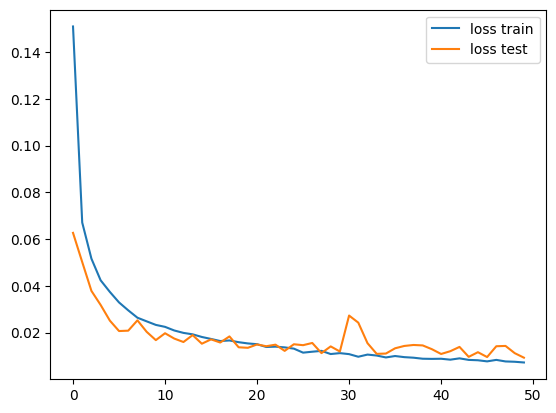

In [11]:
train_a_model(model_1,train_loader,test_set,epochs = epochs,lr=1e-3,outmodelname='../models/C1.pkl')

              precision    recall  f1-score   support

           0      0.992     0.993     0.992     18118
           1      0.836     0.824     0.830       556
           2      0.966     0.959     0.963      1448
           3      0.805     0.840     0.822       162
           4      0.993     0.992     0.993      1608

    accuracy                          0.985     21892
   macro avg      0.918     0.921     0.920     21892
weighted avg      0.985     0.985     0.985     21892



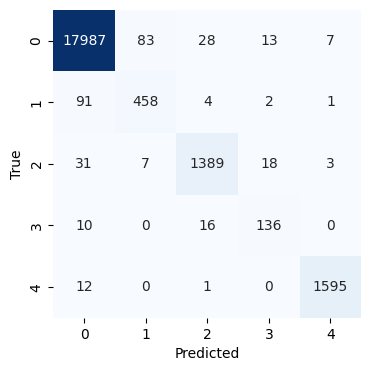

In [45]:
model_1=joblib.load('../models/C1.pkl')
y_true, y_pred, accuracy, recall, loss = evaluate_model(model_1, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

### kernels

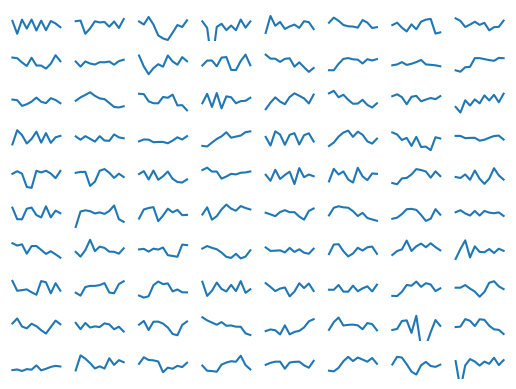

In [61]:
layer1 = model_1[0]
N = layer1.weight.shape[0]
fig,ax = plt.subplots(nrows=10,ncols=8)
ax =ax.flatten()
for k in range(min(N,80)):
    ax[k].plot(layer1.weight[k,0,:].detach().numpy())
    ax[k].set_axis_off()
    ax[k].set_ylim([-1.2,1.2])

## Kernels 5,3,3

In [13]:
model_2 = cnn_type_2()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            480
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            19,280
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           84,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           255
Total params: 123,825
Trainable params: 123,825
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.1534481108793441, --- Val loss 0.062033940106630325, --- accuray : 0.977749961842498, --- recall : 0.9777294417928925


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.06979038357000579, --- Val loss 0.04368498548865318, --- accuray : 0.9850701617305788, --- recall : 0.9849999167134914


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.052432469541371304, --- Val loss 0.038951221853494644, --- accuray : 0.9870624974010347, --- recall : 0.9870256745406303


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.04368795359622249, --- Val loss 0.02704278938472271, --- accuray : 0.9915772914993163, --- recall : 0.9915692077603154


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 5/50 -- Training loss 0.03784884252590949, --- Val loss 0.028376685455441475, --- accuray : 0.9907940159428685, --- recall : 0.9907318841231441


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.0337515366890139, --- Val loss 0.02205459214746952, --- accuray : 0.9933566512941775, --- recall : 0.9933658614180818


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 7/50 -- Training loss 0.029659760648192948, --- Val loss 0.02690032497048378, --- accuray : 0.9914096362771059, --- recall : 0.9913466900726376


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.02934490203763605, --- Val loss 0.023446137085556984, --- accuray : 0.9929174478009664, --- recall : 0.992921197215767


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 9/50 -- Training loss 0.02611258799791925, --- Val loss 0.03480219468474388, --- accuray : 0.9895100756608816, --- recall : 0.989465907993119


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.026204185242172304, --- Val loss 0.020153459161520004, --- accuray : 0.9936979340660642, --- recall : 0.9936980269440948


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 11/50 -- Training loss 0.02291442955794114, --- Val loss 0.01668112352490425, --- accuray : 0.9954119980437133, --- recall : 0.9954212790371709


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.02263748841359869, --- Val loss 0.021876079961657524, --- accuray : 0.9942414525864761, --- recall : 0.9942603661904672


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.021220804474415832, --- Val loss 0.017284637317061424, --- accuray : 0.9951948210150172, --- recall : 0.9952072253118096


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 14/50 -- Training loss 0.020315904333651654, --- Val loss 0.014238912612199783, --- accuray : 0.9960775322523412, --- recall : 0.9960911813608533


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 15/50 -- Training loss 0.019020137241877177, --- Val loss 0.01945202611386776, --- accuray : 0.9946840643187871, --- recall : 0.9946850033909946


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.019224977762253462, --- Val loss 0.015056653879582882, --- accuray : 0.99570325631404, --- recall : 0.9957191290297931


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.017239730017704836, --- Val loss 0.01494373008608818, --- accuray : 0.9959419760850846, --- recall : 0.995959843331843


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 18/50 -- Training loss 0.01687914540058495, --- Val loss 0.02055983431637287, --- accuray : 0.9947351881275255, --- recall : 0.9947446946145622


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 19/50 -- Training loss 0.016953888644515674, --- Val loss 0.018104106187820435, --- accuray : 0.9954130991605004, --- recall : 0.9954290678348905


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 20/50 -- Training loss 0.016521761438264924, --- Val loss 0.020864393562078476, --- accuray : 0.9947018268359447, --- recall : 0.9947098632684392


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.016293812736398062, --- Val loss 0.015688708052039146, --- accuray : 0.9954944456578714, --- recall : 0.9954969121640957


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 22/50 -- Training loss 0.01590454912361961, --- Val loss 0.01732260175049305, --- accuray : 0.9953021316791612, --- recall : 0.9953159967581341


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.014385585575052947, --- Val loss 0.022427627816796303, --- accuray : 0.9944359541580738, --- recall : 0.9944465163369814


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.01436742725495338, --- Val loss 0.014514178037643433, --- accuray : 0.99605002494228, --- recall : 0.996063448218386


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 25/50 -- Training loss 0.013723691085129223, --- Val loss 0.013901077210903168, --- accuray : 0.996501476247688, --- recall : 0.9965196512615748


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 26/50 -- Training loss 0.014598761616019628, --- Val loss 0.022997897118330002, --- accuray : 0.9950206736179016, --- recall : 0.9950372693259831


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 27/50 -- Training loss 0.013207351305272074, --- Val loss 0.013742075301706791, --- accuray : 0.9965275851112343, --- recall : 0.9965458091352165


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 28/50 -- Training loss 0.013139213653326699, --- Val loss 0.023775501176714897, --- accuray : 0.9948933369495843, --- recall : 0.9949082632660564


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.012474969341322055, --- Val loss 0.015345102176070213, --- accuray : 0.996395707034656, --- recall : 0.9964160969602608


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.012824548894592547, --- Val loss 0.021918823942542076, --- accuray : 0.994634517034237, --- recall : 0.9946392591501201


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 31/50 -- Training loss 0.011760260423384726, --- Val loss 0.012208468280732632, --- accuray : 0.9970645314162443, --- recall : 0.9970805765478913


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.011989918511088035, --- Val loss 0.01380816102027893, --- accuray : 0.9967184855329883, --- recall : 0.9967304044600074


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.01140670147650406, --- Val loss 0.015603406354784966, --- accuray : 0.9961297289022356, --- recall : 0.9961457233526504


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.011353453709627502, --- Val loss 0.011583149433135986, --- accuray : 0.9970609641394714, --- recall : 0.9970763160274838


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.011283051011967473, --- Val loss 0.01549142599105835, --- accuray : 0.9957093494265681, --- recall : 0.9957167677632395


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.010363475948768288, --- Val loss 0.014324941672384739, --- accuray : 0.9967703141170775, --- recall : 0.9967919156587695


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.010287563960658564, --- Val loss 0.020544040948152542, --- accuray : 0.9952845646744916, --- recall : 0.9953062203958204


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.010526582692594329, --- Val loss 0.014445984736084938, --- accuray : 0.9964794146682117, --- recall : 0.9964988505405925


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.010563911298795895, --- Val loss 0.018335245549678802, --- accuray : 0.995840305076652, --- recall : 0.995859402973918


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.0089213234961735, --- Val loss 0.03030255250632763, --- accuray : 0.9940217496068545, --- recall : 0.994037282286347


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.009293384651932336, --- Val loss 0.015255436301231384, --- accuray : 0.9969048959533431, --- recall : 0.9969198545248193


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.010028985040323759, --- Val loss 0.01382053829729557, --- accuray : 0.9969346418009923, --- recall : 0.9969412738270613


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 43/50 -- Training loss 0.009029140103886595, --- Val loss 0.011505513451993465, --- accuray : 0.997461188849981, --- recall : 0.9974749240328389


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.008926298138778774, --- Val loss 0.01027393527328968, --- accuray : 0.9974360982704764, --- recall : 0.9974527439031451


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 45/50 -- Training loss 0.00866605755902428, --- Val loss 0.00978807732462883, --- accuray : 0.9979156319351216, --- recall : 0.9979291373323738


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.008514806425266322, --- Val loss 0.012326433323323727, --- accuray : 0.9971744761901811, --- recall : 0.9971800570576281


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.009213043946461098, --- Val loss 0.00961906649172306, --- accuray : 0.9975952410398484, --- recall : 0.9976094144844883


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.0082538388126737, --- Val loss 0.01575675792992115, --- accuray : 0.9966908808294839, --- recall : 0.9967081935932433


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.00835924985292053, --- Val loss 0.012338959611952305, --- accuray : 0.9972489819005256, --- recall : 0.9972667159916039


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.008822395285161827, --- Val loss 0.012150758877396584, --- accuray : 0.9973028796011671, --- recall : 0.997321469945471
execution time:  4956.9064247608185
Predicted     0     1     2     3     4
True                                   
0          7482    45    16     8     9
1             2  7431     1     0     0
2             0     4  7457     7     0
3             5     0     1  7481     0
4             3     0     0     0  7548
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7560
           1       0.99      1.00      1.00      7434
           2       1.00      1.00      1.00      7468
           3       1.00      1.00      1.00      7487
           4       1.00      1.00      1.00      7551

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



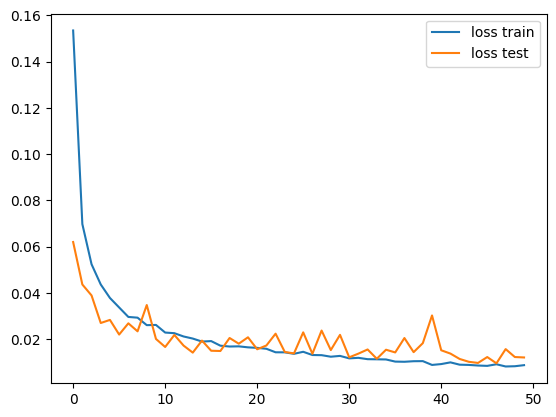

In [14]:
train_a_model(model_2,train_loader,test_set,epochs = epochs,lr=1e-3,outmodelname='../models/C2.pkl')

              precision    recall  f1-score   support

           0      0.993     0.993     0.993     18118
           1      0.852     0.831     0.842       556
           2      0.973     0.957     0.965      1448
           3      0.783     0.846     0.813       162
           4      0.989     0.994     0.992      1608

    accuracy                          0.986     21892
   macro avg      0.918     0.924     0.921     21892
weighted avg      0.986     0.986     0.986     21892



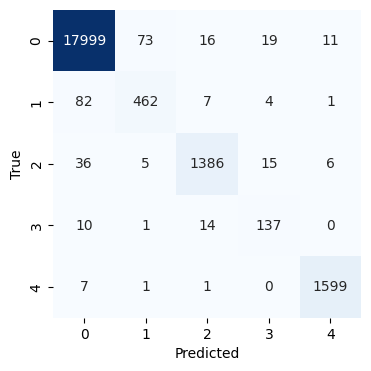

In [52]:
model_2=joblib.load('../models/C2.pkl')

y_true, y_pred, accuracy, recall, loss = evaluate_model(model_2, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

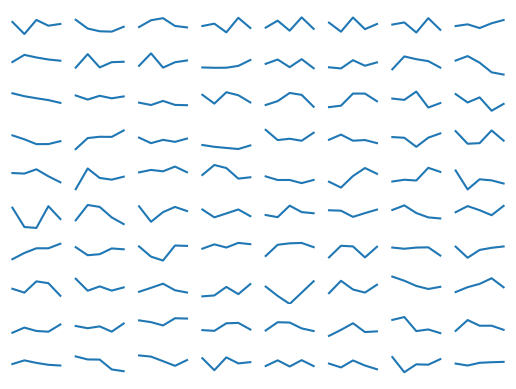

In [62]:
layer1 = model_2[0]
N = layer1.weight.shape[0]
fig,ax = plt.subplots(nrows=10,ncols=8)
ax =ax.flatten()
for k in range(min(N,80)):
    ax[k].plot(layer1.weight[k,0,:].detach().numpy())
    ax[k].set_axis_off()
    ax[k].set_ylim([-1.2,1.2])

## Kernels 7,5,3

In [16]:
model_3 = cnn_type_3()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            640
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       160
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            32,080
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       160
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            19,280
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      160
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           80,050
├─ReLU: 1-16                             --
├─Linear: 1-17                           255
Total params: 132,785
Trainable params: 132,785
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.1512589859511046, --- Val loss 0.06367692351341248, --- accuray : 0.9790058991044959, --- recall : 0.9788825671539113


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.06743301065167522, --- Val loss 0.038479190319776535, --- accuray : 0.9869075410922038, --- recall : 0.98686290114568


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.050296788950012446, --- Val loss 0.035700228065252304, --- accuray : 0.9884077542641808, --- recall : 0.9883758516137462


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.04218955685573575, --- Val loss 0.02788548171520233, --- accuray : 0.9908327747787352, --- recall : 0.9908303083321183


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.03724366272744887, --- Val loss 0.02489139325916767, --- accuray : 0.9926889291433459, --- recall : 0.992699106544791


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.03298928667422767, --- Val loss 0.02213277854025364, --- accuray : 0.9928864646164334, --- recall : 0.9928945617952705


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 7/50 -- Training loss 0.029803591846502112, --- Val loss 0.025017352774739265, --- accuray : 0.9928111256888226, --- recall : 0.9928104569998946


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.02746148084323196, --- Val loss 0.02428998425602913, --- accuray : 0.992580547283082, --- recall : 0.9925685507488357


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 9/50 -- Training loss 0.025591320210629525, --- Val loss 0.017696311697363853, --- accuray : 0.9943796571440757, --- recall : 0.9943762744465179


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 10/50 -- Training loss 0.02475058410082848, --- Val loss 0.016679804772138596, --- accuray : 0.9948046329859294, --- recall : 0.9948142701317136


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.02231990615065511, --- Val loss 0.018401751294732094, --- accuray : 0.9945954202318761, --- recall : 0.9945987369265895


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 12/50 -- Training loss 0.022324598694418777, --- Val loss 0.019691944122314453, --- accuray : 0.9946996312218648, --- recall : 0.9947084451262971


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 13/50 -- Training loss 0.02114983469830237, --- Val loss 0.017082445323467255, --- accuray : 0.9946143605592926, --- recall : 0.9946228368439627


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 14/50 -- Training loss 0.019708305091191397, --- Val loss 0.016045235097408295, --- accuray : 0.9958642743826418, --- recall : 0.9958772932130833


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 15/50 -- Training loss 0.018328528241242405, --- Val loss 0.016786590218544006, --- accuray : 0.9953445477237401, --- recall : 0.9953394363365206


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.01858907393968034, --- Val loss 0.01785757578909397, --- accuray : 0.9956315166011486, --- recall : 0.995645870392383


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.01616714317973032, --- Val loss 0.01690446212887764, --- accuray : 0.9953111924980892, --- recall : 0.9953230916602628


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 18/50 -- Training loss 0.01712124024173125, --- Val loss 0.01522289589047432, --- accuray : 0.9959985699791669, --- recall : 0.9960129748962313


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 19/50 -- Training loss 0.01633468760015496, --- Val loss 0.013206359930336475, --- accuray : 0.9963416665629701, --- recall : 0.9963601318903137


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 20/50 -- Training loss 0.015815703134884482, --- Val loss 0.018800707533955574, --- accuray : 0.9953386260966084, --- recall : 0.9953527426786983


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.01576288957505569, --- Val loss 0.012408696115016937, --- accuray : 0.9962199906630615, --- recall : 0.996212663485939


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 22/50 -- Training loss 0.014563701416362379, --- Val loss 0.015643907710909843, --- accuray : 0.9957938349844463, --- recall : 0.9958029450771531


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.013976972464556372, --- Val loss 0.015617094933986664, --- accuray : 0.9954511145813244, --- recall : 0.9954451280454988


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.014341266435786298, --- Val loss 0.014383704401552677, --- accuray : 0.9961049376733306, --- recall : 0.9961156609199111


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.013322543756610898, --- Val loss 0.013749181292951107, --- accuray : 0.9961316404405286, --- recall : 0.9961422643004404


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 26/50 -- Training loss 0.01330688398671405, --- Val loss 0.012253720313310623, --- accuray : 0.9966638041253543, --- recall : 0.9966721855780742


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.012733168761786895, --- Val loss 0.014748441986739635, --- accuray : 0.9962408253788251, --- recall : 0.9962530543609711


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.01237298699115533, --- Val loss 0.01329361367970705, --- accuray : 0.9967970142236489, --- recall : 0.9968096399935227


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.01316153699683919, --- Val loss 0.02005978673696518, --- accuray : 0.9952866963033007, --- recall : 0.9953012042107037


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.01237210973819567, --- Val loss 0.016081703826785088, --- accuray : 0.9961085781445199, --- recall : 0.9961228177593264


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 31/50 -- Training loss 0.011435868254713783, --- Val loss 0.011866620741784573, --- accuray : 0.9967984226943274, --- recall : 0.9968062971551392


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 32/50 -- Training loss 0.011031754660428038, --- Val loss 0.011465623043477535, --- accuray : 0.9970889801611079, --- recall : 0.9971037109361124


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.010854137669253867, --- Val loss 0.011598579585552216, --- accuray : 0.9970884133876311, --- recall : 0.997100129399145


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.011761911280281364, --- Val loss 0.013973996043205261, --- accuray : 0.9966628403575992, --- recall : 0.996682445585426


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.010580250036924553, --- Val loss 0.013576310127973557, --- accuray : 0.9969026768381255, --- recall : 0.9969184827219625


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.010531942764851171, --- Val loss 0.017974022775888443, --- accuray : 0.9958193102180083, --- recall : 0.9958207988851051


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 37/50 -- Training loss 0.009853079232696687, --- Val loss 0.011353450827300549, --- accuray : 0.9974624036100405, --- recall : 0.9974760963790767


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.010112403032982163, --- Val loss 0.012726815417408943, --- accuray : 0.9970379668918594, --- recall : 0.9970498162464512


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.010354726231399956, --- Val loss 0.012424778193235397, --- accuray : 0.9969569571129574, --- recall : 0.9969705355995115


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.009223510952137182, --- Val loss 0.013413767330348492, --- accuray : 0.9969588387922466, --- recall : 0.9969711623996529


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.009021591285036051, --- Val loss 0.012493491172790527, --- accuray : 0.9965312297005047, --- recall : 0.9965401554427601


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 42/50 -- Training loss 0.009125827418774646, --- Val loss 0.015918483957648277, --- accuray : 0.9962665073802285, --- recall : 0.9962744125931238


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 43/50 -- Training loss 0.009147444168359952, --- Val loss 0.01440813485532999, --- accuray : 0.9970895620638197, --- recall : 0.9971086640579955


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.008681593130315591, --- Val loss 0.01455782726407051, --- accuray : 0.9970628975577573, --- recall : 0.9970792294335002


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 45/50 -- Training loss 0.008836988777156768, --- Val loss 0.01211714930832386, --- accuray : 0.9973831229238261, --- recall : 0.997399625062149


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.00836196360281985, --- Val loss 0.01684829406440258, --- accuray : 0.9964251825291598, --- recall : 0.9964465292354918


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 47/50 -- Training loss 0.008205360204839642, --- Val loss 0.012575286440551281, --- accuray : 0.9974637421096515, --- recall : 0.9974760118013608


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.00920308324099305, --- Val loss 0.015476461499929428, --- accuray : 0.996745276658203, --- recall : 0.9967641751009431


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.007775548437057617, --- Val loss 0.012196818366646767, --- accuray : 0.9974369990936266, --- recall : 0.9974499462113865


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.007433882079181892, --- Val loss 0.014908271841704845, --- accuray : 0.9971165437554351, --- recall : 0.9971340474587034
execution time:  5413.256569623947
Predicted     0     1     2     3     4
True                                   
0          7479    41    17    13    10
1             5  7428     1     0     0
2             1     0  7451    16     0
3             0     0     2  7485     0
4             2     0     0     0  7549
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7560
           1       0.99      1.00      1.00      7434
           2       1.00      1.00      1.00      7468
           3       1.00      1.00      1.00      7487
           4       1.00      1.00      1.00      7551

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



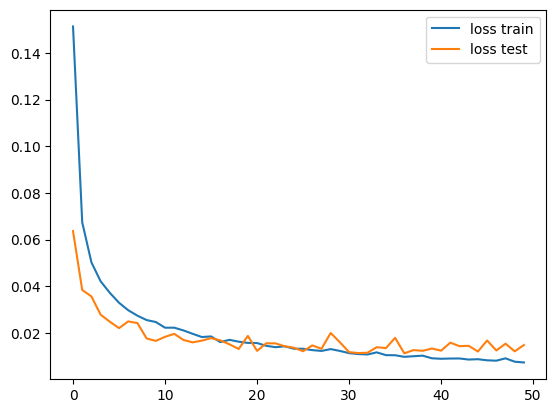

In [17]:
train_a_model(model_3,train_loader,test_set,epochs = epochs,lr=1e-3,outmodelname='../models/C3.pkl')

              precision    recall  f1-score   support

           0      0.993     0.992     0.993     18118
           1      0.827     0.851     0.839       556
           2      0.958     0.963     0.960      1448
           3      0.778     0.846     0.811       162
           4      0.994     0.989     0.991      1608

    accuracy                          0.985     21892
   macro avg      0.910     0.928     0.919     21892
weighted avg      0.985     0.985     0.985     21892



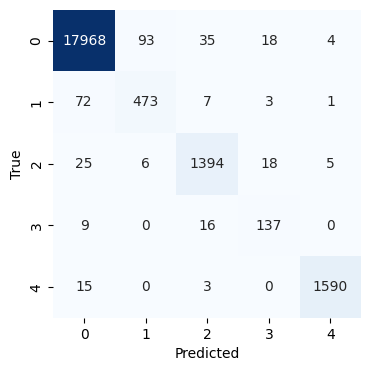

In [55]:
model_3=joblib.load('../models/C3.pkl')

y_true, y_pred, accuracy, recall, loss = evaluate_model(model_3, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

### filters

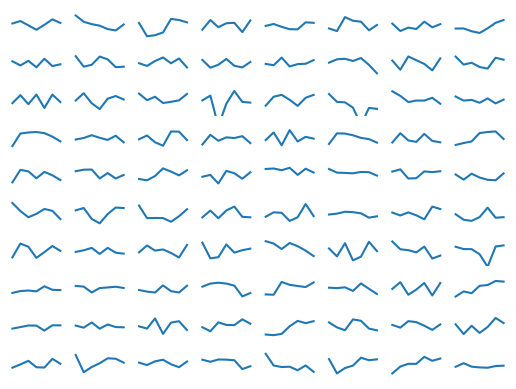

In [63]:
layer1 = model_3[0]
N = layer1.weight.shape[0]
fig,ax = plt.subplots(nrows=10,ncols=8)
ax =ax.flatten()
for k in range(min(N,80)):
    ax[k].plot(layer1.weight[k,0,:].detach().numpy())
    ax[k].set_axis_off()
    ax[k].set_ylim([-1.2,1.2])

## Kernels 5,3,3, increasing number of filters

In [19]:
model_4 = cnn_type_4()

Layer (type:depth-idx)                   Param #
├─Conv1d: 1-1                            192
├─ReLU: 1-2                              --
├─BatchNorm1d: 1-3                       64
├─MaxPool1d: 1-4                         --
├─Conv1d: 1-5                            6,208
├─ReLU: 1-6                              --
├─BatchNorm1d: 1-7                       128
├─MaxPool1d: 1-8                         --
├─Conv1d: 1-9                            24,704
├─ReLU: 1-10                             --
├─BatchNorm1d: 1-11                      256
├─MaxPool1d: 1-12                        --
├─Flatten: 1-13                          --
├─Dropout: 1-14                          --
├─Linear: 1-15                           134,450
├─ReLU: 1-16                             --
├─Linear: 1-17                           255
Total params: 166,257
Trainable params: 166,257
Non-trainable params: 0


C:\Users\passage\Documents\perso\TEST\WinPython\WPy64-31020\scripts\heartbeat\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 1/50 -- Training loss 0.1365398011317148, --- Val loss 0.06936433911323547, --- accuray : 0.9773756540235958, --- recall : 0.9772815252412388


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 2/50 -- Training loss 0.06106623039328877, --- Val loss 0.03830910101532936, --- accuray : 0.9871120080735516, --- recall : 0.9870961608966435


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 3/50 -- Training loss 0.04638591782984269, --- Val loss 0.03383664786815643, --- accuray : 0.9889022906618962, --- recall : 0.9888738009563719


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 4/50 -- Training loss 0.038605241623953644, --- Val loss 0.028994878754019737, --- accuray : 0.9910415520170286, --- recall : 0.9909975415456257


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 5/50 -- Training loss 0.03330357499085093, --- Val loss 0.02710973657667637, --- accuray : 0.9915106714381305, --- recall : 0.9914677466658267


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 6/50 -- Training loss 0.02888061394618468, --- Val loss 0.024505218490958214, --- accuray : 0.9924661617624629, --- recall : 0.9924601805818364


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 7/50 -- Training loss 0.02703487875229364, --- Val loss 0.0213325098156929, --- accuray : 0.9938792429210321, --- recall : 0.993868837798496


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 8/50 -- Training loss 0.024909029527319087, --- Val loss 0.026301216334104538, --- accuray : 0.991942364762655, --- recall : 0.9919123978629388


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 9/50 -- Training loss 0.023389336617803885, --- Val loss 0.019965648651123047, --- accuray : 0.9935827449793587, --- recall : 0.9935792323367634


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 10/50 -- Training loss 0.022026675020628744, --- Val loss 0.0290059894323349, --- accuray : 0.9925429554327758, --- recall : 0.9925561201038644


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 11/50 -- Training loss 0.019868869220894446, --- Val loss 0.025715770199894905, --- accuray : 0.992492121044797, --- recall : 0.9924776858295589


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 12/50 -- Training loss 0.019359461124764707, --- Val loss 0.023279862478375435, --- accuray : 0.993916891400203, --- recall : 0.9939244849726329


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 13/50 -- Training loss 0.017585050853857812, --- Val loss 0.016277814283967018, --- accuray : 0.9957300050274845, --- recall : 0.9957478053603577


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 14/50 -- Training loss 0.018547688234653942, --- Val loss 0.019772663712501526, --- accuray : 0.9949094783100471, --- recall : 0.9949265626897754


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 15/50 -- Training loss 0.016668650504259218, --- Val loss 0.015971504151821136, --- accuray : 0.9958708433790573, --- recall : 0.9958840536275767


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 16/50 -- Training loss 0.015908260432882182, --- Val loss 0.015099436976015568, --- accuray : 0.9954431898093148, --- recall : 0.9954388956629925


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 17/50 -- Training loss 0.015680594601855023, --- Val loss 0.02016032114624977, --- accuray : 0.9952081101038243, --- recall : 0.995224657869854


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 18/50 -- Training loss 0.015245501622406343, --- Val loss 0.021570930257439613, --- accuray : 0.9941043233042862, --- recall : 0.9941036671426119


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 19/50 -- Training loss 0.014401632358548393, --- Val loss 0.014232629910111427, --- accuray : 0.9960526905387121, --- recall : 0.9960566984792483


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 20/50 -- Training loss 0.015307581819267023, --- Val loss 0.014707027934491634, --- accuray : 0.9962646925192548, --- recall : 0.996277144333861


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 21/50 -- Training loss 0.014438344334556699, --- Val loss 0.02866874262690544, --- accuray : 0.9903945802366045, --- recall : 0.9901544098866815


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 22/50 -- Training loss 0.01313708042507599, --- Val loss 0.014856754802167416, --- accuray : 0.9965023552778683, --- recall : 0.996521066415832


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 23/50 -- Training loss 0.012361908552264461, --- Val loss 0.02252947725355625, --- accuray : 0.9950467211291036, --- recall : 0.9950624886931827


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 24/50 -- Training loss 0.012778602862486877, --- Val loss 0.020756416022777557, --- accuray : 0.9949976920256148, --- recall : 0.9950074063454778


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 25/50 -- Training loss 0.012396113267587197, --- Val loss 0.016585778445005417, --- accuray : 0.9962935669025942, --- recall : 0.996310356677862


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 26/50 -- Training loss 0.011496994258721208, --- Val loss 0.014222715049982071, --- accuray : 0.9966904835720681, --- recall : 0.9967041472690523


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 27/50 -- Training loss 0.013005794897438297, --- Val loss 0.015513258054852486, --- accuray : 0.996321684713237, --- recall : 0.9963247073282826


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 28/50 -- Training loss 0.010703722948569788, --- Val loss 0.014340084977447987, --- accuray : 0.9969058003868605, --- recall : 0.9969191122283618


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 29/50 -- Training loss 0.010880456448042423, --- Val loss 0.015529471449553967, --- accuray : 0.9964792395579314, --- recall : 0.9964900278832621


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 30/50 -- Training loss 0.010052508094381638, --- Val loss 0.019204063341021538, --- accuray : 0.9963458991230674, --- recall : 0.9963674670713372


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 31/50 -- Training loss 0.010790026794674385, --- Val loss 0.010357893072068691, --- accuray : 0.9976250191415301, --- recall : 0.9976344524857828


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 32/50 -- Training loss 0.010529682809381592, --- Val loss 0.011788024567067623, --- accuray : 0.9967412072117995, --- recall : 0.9967577125567733


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 33/50 -- Training loss 0.010248342812149638, --- Val loss 0.011619331315159798, --- accuray : 0.9973856935243784, --- recall : 0.9973916031146979


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 34/50 -- Training loss 0.010673887765458438, --- Val loss 0.01800718531012535, --- accuray : 0.996051106735624, --- recall : 0.9960742767621451


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 35/50 -- Training loss 0.009385307254918884, --- Val loss 0.014761238358914852, --- accuray : 0.9969572620132017, --- recall : 0.9969728898005876


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 36/50 -- Training loss 0.009746302968765497, --- Val loss 0.015252018347382545, --- accuray : 0.9970102909125593, --- recall : 0.9970297079816539


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 37/50 -- Training loss 0.009275798667863001, --- Val loss 0.01699732430279255, --- accuray : 0.9967479446097975, --- recall : 0.9967576333145367


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 38/50 -- Training loss 0.009262544886317246, --- Val loss 0.012226172722876072, --- accuray : 0.99727623897633, --- recall : 0.9972919984220369


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 39/50 -- Training loss 0.009303537924450853, --- Val loss 0.014410950243473053, --- accuray : 0.9962937064588806, --- recall : 0.996298579319934


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 40/50 -- Training loss 0.00910454652331999, --- Val loss 0.015665393322706223, --- accuray : 0.9969574177345054, --- recall : 0.9969722946729682


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 41/50 -- Training loss 0.009009669117318615, --- Val loss 0.012989982031285763, --- accuray : 0.9975955611354491, --- recall : 0.9976137018867002


train:   0%|          | 0/2125 [00:00<?, ?it/s]

save model
Epoch : 42/50 -- Training loss 0.008402982091309574, --- Val loss 0.011143420822918415, --- accuray : 0.9976494810081615, --- recall : 0.9976632932449307


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 43/50 -- Training loss 0.007923216216907603, --- Val loss 0.01750299520790577, --- accuray : 0.9965058043120871, --- recall : 0.9965241816897477


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 44/50 -- Training loss 0.008546929115877526, --- Val loss 0.014742840081453323, --- accuray : 0.99695548321302, --- recall : 0.996972541122697


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 45/50 -- Training loss 0.007816171285051273, --- Val loss 0.01468329131603241, --- accuray : 0.9970100189443587, --- recall : 0.99703108399844


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 46/50 -- Training loss 0.008113262564394624, --- Val loss 0.01682475209236145, --- accuray : 0.9966916972292795, --- recall : 0.996705881408644


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 47/50 -- Training loss 0.0076990381396621135, --- Val loss 0.012945466674864292, --- accuray : 0.997518259169183, --- recall : 0.9975288714417786


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 48/50 -- Training loss 0.007424015452522637, --- Val loss 0.01994343101978302, --- accuray : 0.9966136848166878, --- recall : 0.996630645750972


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 49/50 -- Training loss 0.008146166022334672, --- Val loss 0.013337187469005585, --- accuray : 0.9970892993231424, --- recall : 0.9971016668202182


train:   0%|          | 0/2125 [00:00<?, ?it/s]

Epoch : 50/50 -- Training loss 0.007421190450629384, --- Val loss 0.019442807883024216, --- accuray : 0.9963445432754534, --- recall : 0.9963653855117418
execution time:  4934.859855175018
Predicted     0     1     2     3     4
True                                   
0          7457    50    26    19     8
1             3  7428     3     0     0
2             1     0  7446    21     0
3             1     0     0  7486     0
4             2     0     3     0  7546
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7560
           1       0.99      1.00      1.00      7434
           2       1.00      1.00      1.00      7468
           3       0.99      1.00      1.00      7487
           4       1.00      1.00      1.00      7551

    accuracy                           1.00     37500
   macro avg       1.00      1.00      1.00     37500
weighted avg       1.00      1.00      1.00     37500



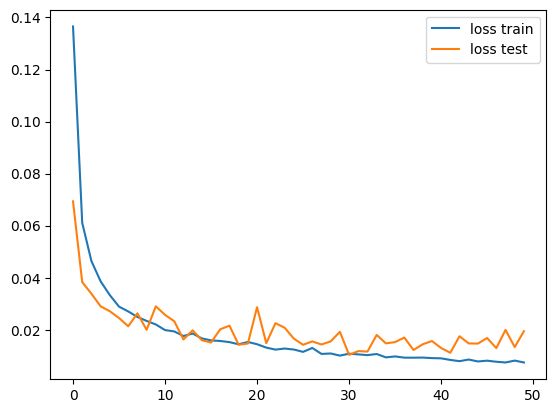

In [20]:
train_a_model(model_4,train_loader,test_set,epochs = epochs,lr=1e-3,outmodelname='../models/C4.pkl')

              precision    recall  f1-score   support

           0      0.992     0.992     0.992     18118
           1      0.853     0.833     0.843       556
           2      0.952     0.961     0.956      1448
           3      0.791     0.796     0.794       162
           4      0.991     0.992     0.992      1608

    accuracy                          0.985     21892
   macro avg      0.916     0.915     0.915     21892
weighted avg      0.985     0.985     0.985     21892



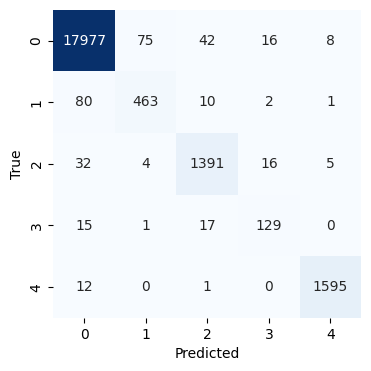

In [57]:
model_4=joblib.load('../models/C4.pkl')

y_true, y_pred, accuracy, recall, loss = evaluate_model(model_4, valid_set)
table = pd.crosstab(y_true,y_pred,rownames=['True'],colnames=['Predicted'])
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()

sns.heatmap(table,cmap='Blues',annot=True,fmt='d',cbar=False,linecolor='black',ax=ax)
ax.set_aspect('equal')
print(classification_report(y_true, y_pred,digits=3))

### filters

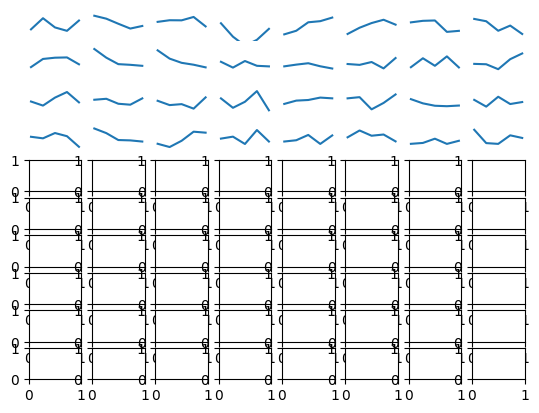

In [60]:
layer1 = model_4[0]
N = layer1.weight.shape[0]
fig,ax = plt.subplots(nrows=10,ncols=8)
ax =ax.flatten()
for k in range(min(N,80)):
    ax[k].plot(layer1.weight[k,0,:].detach().numpy())
    ax[k].set_axis_off()
    ax[k].set_ylim([-1.2,1.2])